In [1]:
import pandas as pd 
from DimRed_plus import PCAAnalysis, UMAPAnalysis
from EDA_tools import DfAnalysis, DataPreprocessing
from sklearn.linear_model import ElasticNetCV

import os 

import warnings
warnings.filterwarnings('ignore')



c:\Users\User\.conda\envs\datascience\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df_ml = pd.read_csv(r"df_ml\df_for_ml.csv")

In [4]:
df_ml.columns

Index(['valeur_fonciere', 'surface_reelle_bati', 'surface_terrain',
       'nombre_pieces_principales', 'longitude', 'latitude', 'carreau_Ind',
       'carreau_Men', 'carreau_Men_pauv', 'carreau_Men_1ind',
       'carreau_Men_5ind', 'carreau_Men_prop', 'carreau_Men_fmp',
       'carreau_Ind_snv', 'carreau_Men_surf', 'carreau_Men_coll',
       'carreau_Men_mais', 'carreau_Log_av45', 'carreau_Log_45_70',
       'carreau_Log_70_90', 'carreau_Log_ap90', 'carreau_Log_inc',
       'carreau_Log_soc', 'carreau_Ind_0_3', 'carreau_Ind_4_5',
       'carreau_Ind_6_10', 'carreau_Ind_11_17', 'carreau_Ind_18_24',
       'carreau_Ind_25_39', 'carreau_Ind_40_54', 'carreau_Ind_55_64',
       'carreau_Ind_65_79', 'carreau_Ind_80p', 'carreau_Ind_inc',
       'carreau_I_pauv', 'carreau_t_maille', 'P16_POP', 'P11_POP', 'SUPERF',
       'NAIS1116', 'DECE1116', 'P16_MEN', 'NAISD18', 'DECESD18', 'P16_LOG',
       'P16_RP', 'P16_RSECOCC', 'P16_LOGVAC', 'P16_RP_PROP', 'NBMENFISC16',
       'MED16', 'P16_EMPLT', 

Notre objectif dans ce notebook est de réaliser une sélection de variables, nous devons dès lors:

- repérer les variables corrélées linéairement
- comprendre si le prix est plutôt obtenu par une fonction linéaire des autres variables ou non linéaire
    - On verra en utilisant UMAP et PCA lequel des algorithmes offre une clusterisation plus efficace
- construire un sous dataset de biens aux caractéristiques comparables et voir quel est l'impact de leur localisation sur leur prix
    - On pourra par exemple afficher une distribution des distances au centre de Toulouse pour construire plusieurs classes de proximité au centre dans lesquelles on sélectionnera des biens comparables afin de se rendre compte si les différences de prix sont significatives (en affichant leur distribution par exemple)
    - Nous pourrons ensuite comparer cette distribution à la distribution initiale


Avant de mener une PCA et d'utiliser un modèle de ML il est essentiel de: 
- retirer les éléments outliers
- retirer de l'étude les variables non discriminantes, qui présentent une très faible variabilité

In [5]:
cols_to_drop1 = ['P16_POP', 'P11_POP', 'SUPERF',
       'NAIS1116', 'DECE1116', 'P16_MEN', 'NAISD18', 'DECESD18', 'P16_LOG',
       'P16_RP', 'P16_RSECOCC', 'P16_LOGVAC', 'P16_RP_PROP', 'NBMENFISC16', 
       'P16_EMPLT', 'P16_EMPLT_SAL', 'P11_EMPLT', 'P16_POP1564',
       'P16_CHOM1564', 'P16_ACT1564', 'ETTOT15', 'ETAZ15', 'ETBE15', 'ETFZ15',
       'ETGU15', 'ETGZ15', 'ETOQ15', 'ETTEF115', 'ETTEFP1015']

df_ml_select = df_ml.drop(cols_to_drop1, axis=1)
df_ml_select.shape

(3939, 48)

Nous n'avons "plus que" 46 variables, occupons nous à présent des outliers, mais attention: rappelons que notre dataset est déséquilibré 

In [6]:
ana_df_ml_select = DfAnalysis(df_ml_select)
_, pct = ana_df_ml_select.identify_outliers(method='iqr', threshold=2)
pct

valeur_fonciere               3.503427
surface_reelle_bati           2.234070
surface_terrain               6.702209
nombre_pieces_principales     0.660066
longitude                     3.249556
latitude                      5.559787
carreau_Ind                   0.000000
carreau_Men                   1.980198
carreau_Men_pauv              6.346789
carreau_Men_1ind              5.077431
carreau_Men_5ind              2.564103
carreau_Men_prop              1.980198
carreau_Men_fmp               0.000000
carreau_Ind_snv               1.980198
carreau_Men_surf              1.980198
carreau_Men_coll              4.011170
carreau_Men_mais              0.558517
carreau_Log_av45             11.018025
carreau_Log_45_70            14.673775
carreau_Log_70_90             3.224169
carreau_Log_ap90              3.224169
carreau_Log_inc               9.164763
carreau_Log_soc               7.108403
carreau_Ind_0_3               1.294745
carreau_Ind_4_5               1.700939
carreau_Ind_6_10         

Les outliers n'influencent que peu les modèles à base d'arbres de décisions que nous entendons utiliser dans ce case, nous ne les traitons donc pas, bien que l'on pourrait appliquer cette ligne: `ana_df_ml_select.handle_outliers(method=median, replacement_method=median)` 

In [7]:
ana_df_ml_select.plot_boxplots()

{'valeur_fonciere': <Axes: title={'center': 'Boxplot of valeur_fonciere'}, xlabel='valeur_fonciere'>,
 'surface_reelle_bati': <Axes: title={'center': 'Boxplot of surface_reelle_bati'}, xlabel='surface_reelle_bati'>,
 'surface_terrain': <Axes: title={'center': 'Boxplot of surface_terrain'}, xlabel='surface_terrain'>,
 'nombre_pieces_principales': <Axes: title={'center': 'Boxplot of nombre_pieces_principales'}, xlabel='nombre_pieces_principales'>,
 'longitude': <Axes: title={'center': 'Boxplot of longitude'}, xlabel='longitude'>,
 'latitude': <Axes: title={'center': 'Boxplot of latitude'}, xlabel='latitude'>,
 'carreau_Ind': <Axes: title={'center': 'Boxplot of carreau_Ind'}, xlabel='carreau_Ind'>,
 'carreau_Men': <Axes: title={'center': 'Boxplot of carreau_Men'}, xlabel='carreau_Men'>,
 'carreau_Men_pauv': <Axes: title={'center': 'Boxplot of carreau_Men_pauv'}, xlabel='carreau_Men_pauv'>,
 'carreau_Men_1ind': <Axes: title={'center': 'Boxplot of carreau_Men_1ind'}, xlabel='carreau_Men_1in

In [8]:
df_ml_select.head()

,valeur_fonciere,surface_reelle_bati,surface_terrain,nombre_pieces_principales,longitude,latitude,carreau_Ind,carreau_Men,carreau_Men_pauv,carreau_Men_1ind,carreau_Men_5ind,carreau_Men_prop,carreau_Men_fmp,carreau_Ind_snv,carreau_Men_surf,carreau_Men_coll,carreau_Men_mais,carreau_Log_av45,carreau_Log_45_70,carreau_Log_70_90,carreau_Log_ap90,carreau_Log_inc,carreau_Log_soc,carreau_Ind_0_3,carreau_Ind_4_5,carreau_Ind_6_10,carreau_Ind_11_17,carreau_Ind_18_24,carreau_Ind_25_39,carreau_Ind_40_54,carreau_Ind_55_64,carreau_Ind_65_79,carreau_Ind_80p,carreau_Ind_inc,carreau_I_pauv,carreau_t_maille,MED16,latitude_comm,longitude_comm,distance_cv_km,distance_toulouse_km,latitude_rad,longitude_rad,prix_moyen_voisins,date_mutation,type_local,agent,evaluation_agent
0,-0.009620,-0.158050,-0.513990,-0.215153,0.772860,0.278483,-0.813875,-0.734127,-0.666421,-0.601571,-0.766623,-0.843016,-0.904847,-0.716066,-0.773703,-0.531069,-1.105694,0.036019,-0.611776,-0.777547,-0.942278,-0.146844,-0.670165,-0.775894,-0.974526,-0.861898,-0.923663,-0.755240,-0.697121,-0.852856,-0.805560,-0.750654,-0.741617,-0.678732,0,-1,-0.558184,0.373784,0.608626,-0.464360,-0.910460,0.278483,0.772860,-0.176897,2014-01-03,Appartement,1,Renove
1,-0.364161,-0.227922,-0.521317,-0.215153,0.917032,0.377750,-0.907731,-0.837318,-0.690719,-0.698245,-0.853750,-0.932727,-0.904847,-0.861109,-0.890035,-0.688870,-0.897696,-0.246477,-0.502422,-0.771080,-0.942278,-0.386394,-0.656684,-0.913757,-0.938514,-0.974119,-0.943872,-0.837951,-0.818284,-0.890062,-0.943905,-0.887769,-0.772986,-0.660785,0,-1,-0.558184,0.373784,0.608626,0.128781,-0.792837,0.377750,0.917032,-0.232458,2014-02-07,Appartement,1,Ancien
2,1.266726,0.540670,-0.440727,0.427370,0.517837,0.684722,-0.978706,-0.910021,-0.800061,-0.777604,-0.853750,-0.979825,-0.996236,-0.910130,-0.946563,-0.757333,-0.937836,-0.314141,-0.611776,-0.809883,-0.953091,-0.386394,-0.670165,-0.936734,-1.010538,-0.994901,-1.024709,-0.920661,-0.882195,-1.008656,-1.015309,-0.913478,-0.757301,-0.858204,0,-1,-0.558184,0.373784,0.608626,-0.052183,-0.774097,0.684722,0.517837,-0.695948,2014-02-18,Appartement,1,Renove
3,-0.383567,-0.460829,-0.545738,-0.215153,0.590012,1.519469,0.327230,0.160982,0.111123,-0.077801,0.435728,-0.109628,0.572598,0.173829,0.203856,0.003282,0.737091,-0.239711,-0.568035,-0.657904,1.321153,-0.027069,0.543118,0.966533,1.033148,0.887925,0.426980,0.547454,0.482558,0.349364,-0.225405,-0.339309,-0.545557,-0.014686,0,0,-0.558184,0.373784,0.608626,2.743193,-0.070835,1.519469,0.590012,-0.986268,2014-02-24,Appartement,1,Renove
4,-1.144150,-0.996515,-0.601906,-0.857676,-0.099236,-0.075345,0.757104,0.476811,0.937263,0.190578,1.725205,0.700014,0.595445,0.464389,0.517459,0.064231,1.944936,-0.353047,-0.605528,2.692113,0.330001,-0.386394,1.264348,1.077589,1.087166,1.286934,0.861476,0.622411,0.318788,0.907455,1.376717,0.920435,0.019093,0.487835,0,0,-0.558184,0.373784,0.608626,0.782745,-0.269024,-0.075345,-0.099236,-1.400195,2014-02-26,Appartement,1,Ancien


In [9]:

umap_analysis = UMAPAnalysis(df_ml_select, target_feature='valeur_fonciere')


umap_analysis.reduce_dimensions(n_components=3)  
umap_analysis.analyze_feature_correlation()
umap_analysis.plot_correlation_heatmaps() 
# aïe soucis insoluble: la légende ne représente qu'une feature sur 2... utiliser l'attribut corr_df
umap_analysis.plot_lowdim(hue='yes',dimension='3d', continuous='yes')


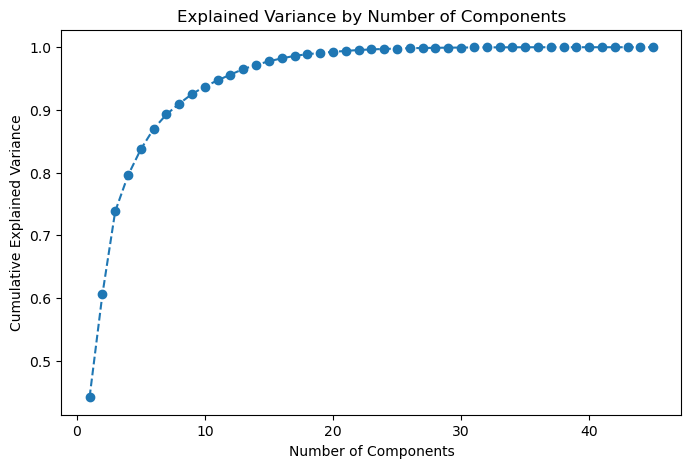

[<Axes: title={'center': 'PC1 Contributions: 44.16431391639103'}>,
 <Axes: title={'center': 'PC2 Contributions: 16.40455816690328'}>,
 <Axes: title={'center': 'PC3 Contributions: 13.244360634548984'}>,
 <Axes: title={'center': 'PC4 Contributions: 5.744767861239546'}>,
 <Axes: title={'center': 'PC5 Contributions: 4.163080787296835'}>,
 <Axes: title={'center': 'PC6 Contributions: 3.2609280541230854'}>,
 <Axes: title={'center': 'PC7 Contributions: 2.293896958930629'}>,
 <Axes: title={'center': 'PC8 Contributions: 1.730715253191466'}>,
 <Axes: title={'center': 'PC9 Contributions: 1.5321034612612396'}>,
 <Axes: title={'center': 'PC10 Contributions: 1.1942976132313277'}>,
 <Axes: title={'center': 'PC11 Contributions: 0.9880714957843736'}>,
 <Axes: title={'center': 'PC12 Contributions: 0.9118755284819189'}>]

In [10]:
pca_analysis = PCAAnalysis(df_ml_select)


pca_analysis.select_n_components()
pca_analysis.plot_pca_components_contributions()

<span style="color:red">**Note:**</span> 

Ces quelques lignes nous ont montré une chose: les composantes d'UMAP n'effectuent pas de réelle discrimination entre nos variables, quelque soit la corrélation étudiée (spearman, pearson ou information mutuelle...), nous n'allons donc pas procéder à une sélection de variables sur cette base.

UMAP permet en revanche de voir un peu mieux à quoi ressemblent nos données qui ne se sont pas trop mal agglomérées dans les représentations 2d et 3d: cela nous permet à minima de comprendre que les différents biens immobiliers sont effectivement différenciés et que l'ensemble de leurs caractéristiques ne prennent pas de valeurs "au hasard".

## Sélection avec Elastic Net

Je ne veux pas procéder à leur sélection en utilisant des arbres de décisions qui sont trop sensibles aux corrélations entre variables:  en effet, bien que les arbres de décision et les forêts aléatoires soient souvent utilisés pour l'importance des variables, ils peuvent en effet être biaisés en faveur de variables ayant un grand nombre de catégories ou étant fortement corrélées avec d'autres. Cette sensibilité peut conduire à une surévaluation de l'importance de certaines variables au détriment d'autres, potentiellement importantes mais moins corrélées. 

Ainsi nous procéderons avec une ElasticNet.

In [11]:
X, y = pd.get_dummies(df_ml_select.drop('valeur_fonciere', axis=1), drop_first=True), df_ml_select['valeur_fonciere']

In [12]:
elastic_net_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
elastic_net_cv.fit(X, y)
print("Alpha optimal (α):", elastic_net_cv.alpha_)
print("Ratio L1 optimal (l1_ratio):", elastic_net_cv.l1_ratio_)


Alpha optimal (α): 0.004085806187437325
Ratio L1 optimal (l1_ratio): 0.9


In [13]:
# Les noms des features après get_dummies
feature_names = X.columns.tolist()

coefficients = elastic_net_cv.coef_
features_df = pd.DataFrame({'Feature_Name': feature_names, 'Coefficient': coefficients})

selected_features_df = features_df[abs(features_df['Coefficient']) > 1e-2]

selected_features_df = selected_features_df.sort_values(by='Coefficient', key=abs, ascending=False)

print(selected_features_df)

                 Feature_Name  Coefficient
0         surface_reelle_bati     0.784283
1392  evaluation_agent_Renove     0.310017
42         prix_moyen_voisins     0.155574
39       distance_toulouse_km    -0.151090
1             surface_terrain     0.059545
32            carreau_Ind_inc     0.057579
34           carreau_t_maille    -0.041221
22            carreau_Ind_0_3    -0.031323
1391        type_local_Maison     0.027246
36              latitude_comm     0.023437
3                   longitude     0.022361
15           carreau_Men_mais    -0.014331
37             longitude_comm    -0.012021


In [14]:
selected_features = selected_features_df['Feature_Name'].tolist()
X_selected = X[selected_features]
ml_selected_byreg = pd.concat([X_selected, y], axis=1)

Nous disposons donc d'une liste de variables obtenues par elastic net, nous devrons les comparer avec des variables que nous auront sélectionnées avec notre bon sens en entraînant différent modèles sur ces deux sélections de variables.

In [15]:
chemin_dossier = r'C:\Users\User\Desktop\Projets en cours\Data_Science\Mini-projets\Case_cap_gemini_emmanuel_benichou\df_ml'
nom_fichier = 'ml_selected_byreg.csv'
chemin_complet = os.path.join(chemin_dossier, nom_fichier)

os.makedirs(chemin_dossier, exist_ok=True)

ml_selected_byreg.to_csv(chemin_complet, index=False, encoding='utf-8')

## Sélection manuelle des variables

Testons notre bon sens!

In [16]:
cols_to_drop2 = [
    # Informations générales sur le carreau
    'carreau_Ind',
    'carreau_Men',
    'carreau_t_maille',
    
    # Informations démographiques sur le carreau
    'carreau_Men_pauv',
    'carreau_Men_1ind',
    'carreau_Men_5ind',
    'carreau_Men_prop',
    'carreau_Men_fmp',
    'carreau_Men_mais',
    'carreau_I_pauv',
    
    # Informations sur le logement dans le carreau 
    # (on considère similaires les logements de ces années/ redondance avec l'état rapporté par l'agent)
    'carreau_Log_70_90',
    'carreau_Log_ap90',
    'carreau_Log_inc',
    'carreau_Log_soc',
    
    # Informations sur les indicateurs démographiques du carreau (concernent l'âge des résidents)
    'carreau_Ind_0_3',
    'carreau_Ind_4_5',
    'carreau_Ind_6_10',
    'carreau_Ind_11_17',
    'carreau_Ind_18_24',
    'carreau_Ind_25_39',
    'carreau_Ind_40_54',
    'carreau_Ind_55_64',
    'carreau_Ind_65_79',
    'carreau_Ind_80p',
    'carreau_Ind_inc',
    
    # Coordonnées géographiques 
    # (éviter les redondances avec les lat/long originales)
    'latitude_comm',
    'longitude_comm',
    'latitude_rad',
    'longitude_rad',
    
    # Date de mutation
    # (on ne mène pas d'analyse temporelle, si l'on veut rendre compte du prix d'un bien en fonction de 
    # ses caractéristiques la date de mutation n'est pas pertinente)
    'date_mutation'
]


In [17]:
ml_selected_byhand = df_ml_select.drop(cols_to_drop2, axis=1)

In [18]:
chemin_dossier = r'C:\Users\User\Desktop\Projets en cours\Data_Science\Mini-projets\Case_cap_gemini_emmanuel_benichou\df_ml'
nom_fichier = 'ml_selected_byhand.csv'
chemin_complet = os.path.join(chemin_dossier, nom_fichier)

os.makedirs(chemin_dossier, exist_ok=True)

ml_selected_byhand.to_csv(chemin_complet, index=False, encoding='utf-8')

**Signification des Variables**

| Variable                | Description                                                                                      | Interprétation                                                       |
|-------------------------|--------------------------------------------------------------------------------------------------|----------------------------------------------------------------------|
| `valeur_fonciere`       | **Valeur foncière** déclarée pour la transaction.                                                | <span style="color:orange">Indicateur clé du prix de vente.</span>   |
| `surface_reelle_bati`   | Surface réelle **bâtie** en mètres carrés.                                                       | <span style="color:orange">Facteur important influençant la valeur foncière.</span> |
| `surface_terrain`       | Surface du **terrain** associé au bien en mètres carrés.                                         | <span style="color:orange">Influe sur la valeur, surtout pour les maisons individuelles.</span> |
| `nombre_pieces_principales` | Nombre de **pièces principales** (hors cuisine, salle de bain, etc.).                         | <span style="color:orange">Reflète la taille et l'habitabilité du logement.</span> |
| `longitude`, `latitude` | Coordonnées géographiques permettant de localiser le bien.                                       | <span style="color:orange">Cruciales pour les analyses spatiales.</span> |
| `carreau_Ind_snv`       | Somme des **niveaux de vie**, ajustée ou winsorisée, des individus dans un carreau.              | <span style="color:orange">Indicateur socio-économique du quartier.</span> |
| `carreau_Men_surf`      | Informations sur la surface des logements des ménages dans le carreau.                           |                                                                      |
| `carreau_Men_coll`      | Nombre de **ménages en collectif** dans le carreau.                                              | <span style="color:orange">Peut indiquer la densité de logements.</span> |
| `carreau_Log_av45`, `carreau_Log_45_70` | Indiquent respectivement le nombre de logements construits **avant 1945** et **entre 1945 et 1970**. | <span style="color:orange">Informations sur l'ancienneté et potentiellement l'état du bâti.</span> |
| `MED16` (MED2016)       | **Médiane du niveau de vie** en 2016.                                                             | <span style="color:orange">Indicateur économique majeur du quartier.</span> |
| `distance_cv_km`, `distance_toulouse_km` | Distances respectives au **centre-ville** le plus proche et à **Toulouse**, en kilomètres.  | <span style="color:orange">Impact potentiel sur l'attractivité du bien.</span> |
| `prix_moyen_voisins`    | Prix moyen des biens immobiliers dans un rayon défini.                                           | <span style="color:orange">Réflecte le marché local.</span>          |
| `type_local`            | Type de bien (appartement, maison...).                                                           | <span style="color:orange">Caractéristique fondamentale du bien.</span> |
| `agent`                 | Identifiant de l'agent immobilier en charge.                                                      | <span style="color:orange">Pour référence interne ou analyse des performances de vente.</span> |
| `evaluation_agent`      | Évaluation du bien par l'agent.                                                                   | <span style="color:orange">Permet de considérer l'état matériel du bien en question.</span> |




Nous pouvons à présent clore cette deuxième partie et nous concentrer sur la troisème et dernière qui consiste en l'entraînement et la comparaison de plusieurs modèles de machine learning visant à prédire la valeur foncière d'un bien en fonction de ses caractéristiques.

## Courte EDA sur les variables sélectionnées à la main

In [20]:
eda_analysis = DfAnalysis(ml_selected_byhand)
eda_analysis.plot_boxplots(title='by_hand')
eda_analysis.plot_pairplot()
eda_analysis.correlation_matrix(title='by_hand')
eda_analysis.plot_categorical_distribution(title='by_hand')
eda_analysis.skewness_kurtosis();

Skewness:
valeur_fonciere              1.733796
surface_reelle_bati          1.370738
surface_terrain              4.237711
nombre_pieces_principales    0.442881
longitude                   -1.317466
latitude                    -1.028609
carreau_Ind_snv              1.555721
carreau_Men_surf             1.383017
carreau_Men_coll             1.691142
carreau_Log_av45             4.234336
carreau_Log_45_70            1.894940
MED16                        2.061120
distance_cv_km               0.838681
distance_toulouse_km         1.369128
prix_moyen_voisins           1.392773
agent                        0.017319
dtype: float64

Kurtosis:
valeur_fonciere               5.638661
surface_reelle_bati           4.172095
surface_terrain              40.264897
nombre_pieces_principales     0.196552
longitude                     1.405938
latitude                      1.077840
carreau_Ind_snv               2.711575
carreau_Men_surf              1.895547
carreau_Men_coll              2.290828
carre